2025-09-09 11:20:04.548774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 11:20:04.549672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 11:20:04.552631: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 11:20:04.560735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757388004.573927   28485 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757388004.57

Loading models...


W0000 00:00:1757388006.641111   28485 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.2 when using version 1.3.0. This mig


Loading and processing data...
Processing features...

Data Shapes:
Source features: (12609, 14)
Target features: (11358, 14)
Expected input shape of logit_extractor: (None, 14, 1)

Performing CORAL-PCA domain adaptation...


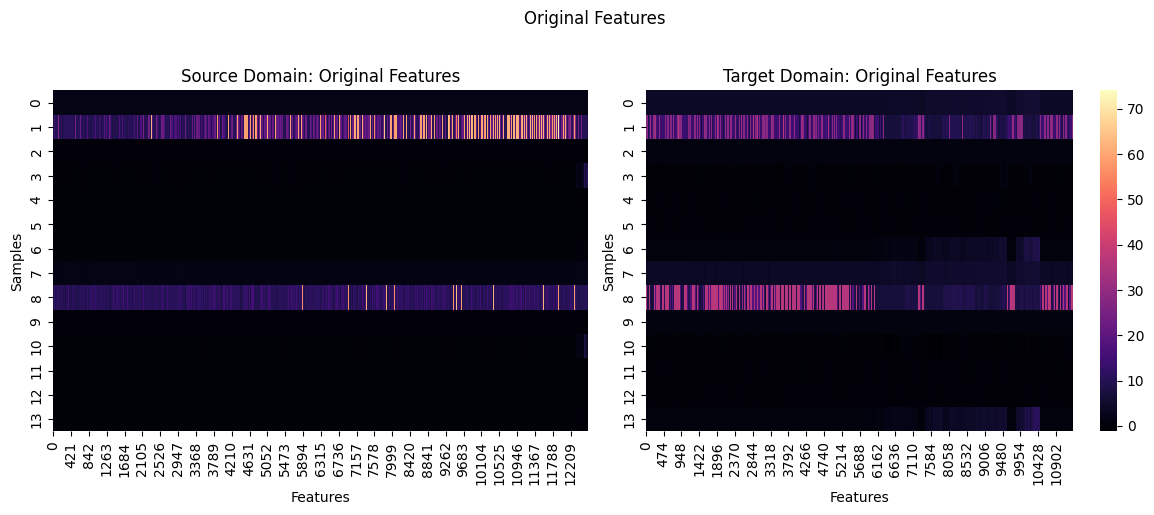

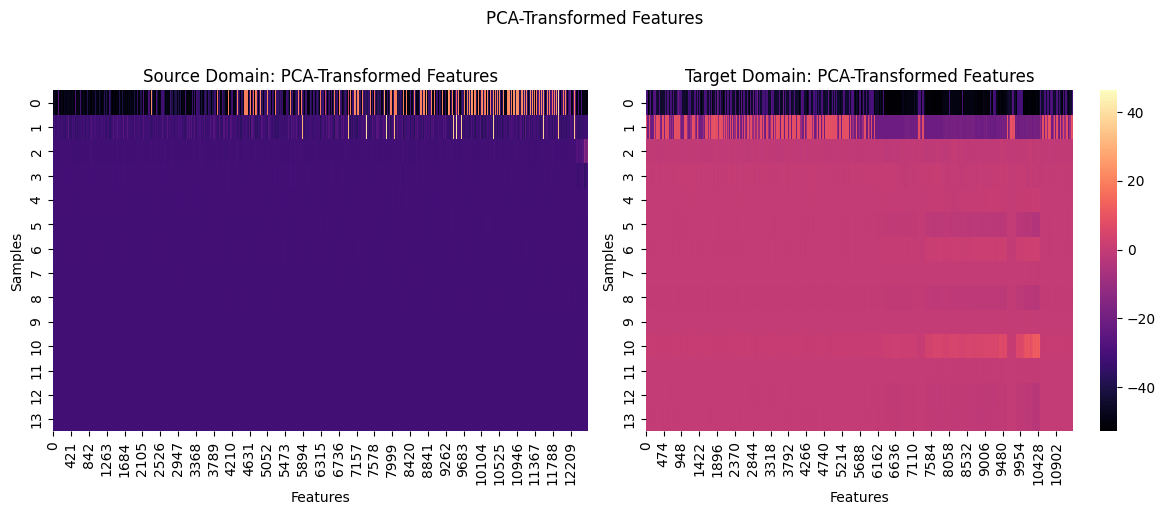

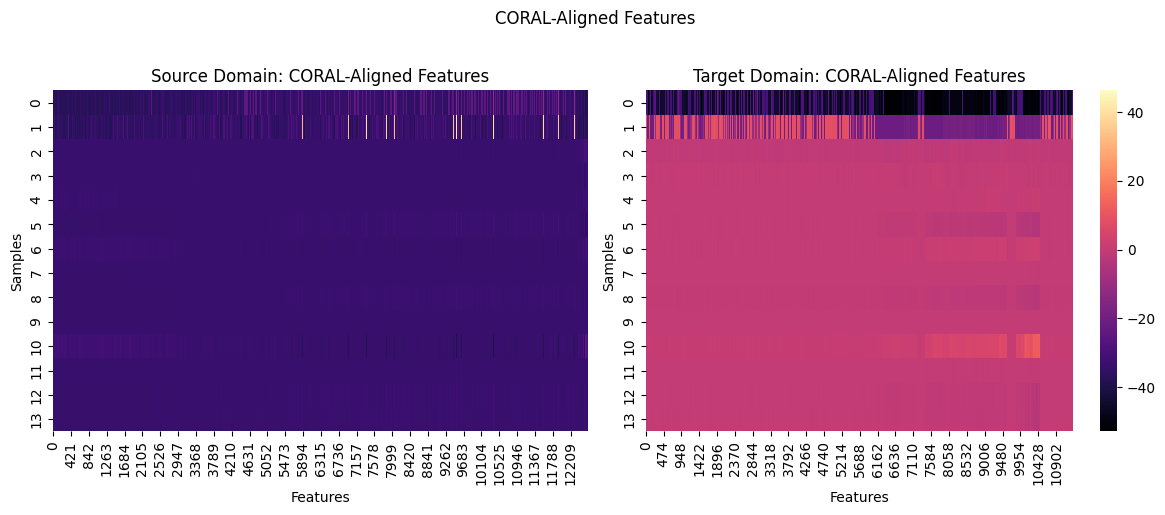


Making predictions with CORAL...
395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step

Making predictions without CORAL alignment...
395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step

Evaluation Metrics:
MSE (With CORAL): 0.0961
MAE (With CORAL): 0.2803
MSE (Without CORAL): 0.1049
MAE (Without CORAL): 0.2919
Score (With CORAL): 297.3991
Score (Without CORAL): 321.7089


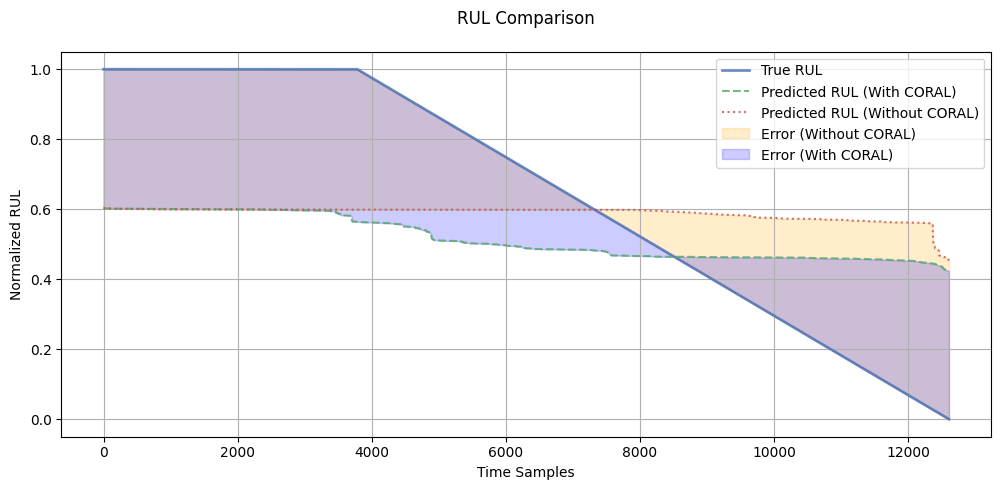

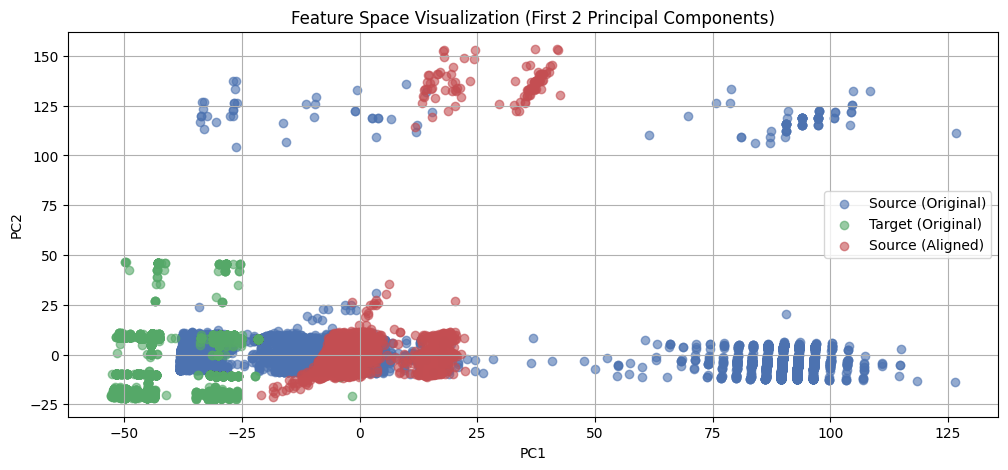

In [1]:
import numpy as np
from scipy.linalg import sqrtm
from keras._tf_keras.keras.models import load_model,Model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from XJTU.utils.preprocess import process_features
import pandas as pd
import os

import numpy as np
from scipy.linalg import sqrtm
from keras._tf_keras.keras.models import load_model, Model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


def score(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    error = y_pred - y_true

    # Masks
    mask_early = error < 0   # early prediction
    mask_late = error >= 0   # late prediction

    # Apply penalties
    score_early = np.sum((np.exp(-error / 13) - 1) * mask_early)
    score_late = np.sum((np.exp(error / 10) - 1) * mask_late)

    return score_early + score_late

# Setup directories
dir = os.getcwd()
xjtu_time_dir = os.path.join(dir, 'XJTU/tf_features')
pronostia_time_dir = os.path.join(dir, 'PRONOSTIA/tf_features')
xjtu_weights_dir = os.path.join(dir, 'XJTU/model_weights')
pronostia_weights_dir = os.path.join(dir, 'PRONOSTIA/model_weights')

bearing = 'Bearing1_5'  # Example bearing
plt.style.use('seaborn-v0_8-deep')


def coral_pca(source, target, n_components=None):
    """CORAL with PCA and proper visualization"""
    source_flat = source.reshape(source.shape[0], -1)
    target_flat = target.reshape(target.shape[0], -1)
    
    # Plot original feature distributions
    plot_feature_comparison(source_flat.T, target_flat.T, "Original Features")
    
    # Dimensionality alignment
    if n_components is None:
        n_components = min(source_flat.shape[1], target_flat.shape[1])
    
    pca = PCA(n_components=n_components)
    source_pca = pca.fit_transform(source_flat)
    target_pca = pca.transform(target_flat)
    
    # Plot PCA-transformed features
    plot_feature_comparison(source_pca.T, target_pca.T, "PCA-Transformed Features")
    
    # CORAL alignment
    source_centered = source_pca - np.mean(source_pca, axis=0)
    target_centered = target_pca - np.mean(target_pca, axis=0)
    
    cov_source = np.cov(source_centered, rowvar=False) + np.eye(source_centered.shape[1]) * 1e-6
    cov_target = np.cov(target_centered, rowvar=False) + np.eye(target_centered.shape[1]) * 1e-6
    
    whitening = sqrtm(np.linalg.inv(cov_source))
    coloring = sqrtm(cov_target)
    transformed = source_centered @ whitening @ coloring
    
    # Plot CORAL-aligned features
    plot_feature_comparison(transformed.T, target_pca.T, "CORAL-Aligned Features")
    
    aligned_data = transformed.reshape(source.shape[0], source.shape[1], -1)
    return np.real(aligned_data), pca


def plot_feature_comparison(source, target, title):
    """Visualize feature distributions before/after alignment"""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(source, cmap='magma', cbar=False)
    plt.title(f"Source Domain: {title}")
    plt.xlabel("Features")
    plt.ylabel("Samples")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(target, cmap='magma')
    plt.title(f"Target Domain: {title}")
    plt.xlabel("Features")
    plt.ylabel("Samples")
    
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()


def plot_rul_comparison(true_rul, pred_rul, pred_rul_no_coral=None):
    """Visualize RUL predictions vs true values, with and without CORAL"""
    plt.figure(figsize=(12, 5))
    plt.plot(true_rul, label='True RUL', linewidth=2, alpha=0.8)
    plt.plot(pred_rul, label='Predicted RUL (With CORAL)', linestyle='--', alpha=0.8)
    if pred_rul_no_coral is not None:
        plt.plot(pred_rul_no_coral, label='Predicted RUL (Without CORAL)', linestyle=':', alpha=0.8)
        plt.fill_between(range(len(true_rul)), true_rul, pred_rul_no_coral, color='orange', alpha=0.2, label='Error (Without CORAL)')
    
    plt.fill_between(range(len(true_rul)), true_rul, pred_rul, color='blue', alpha=0.2, label='Error (With CORAL)')
    plt.title("RUL Comparison", pad=20)
    plt.xlabel("Time Samples")
    plt.ylabel("Normalized RUL")
    plt.legend()
    plt.grid(True)
    plt.show()


# Load models
print("Loading models...")
model = load_model(f'{pronostia_weights_dir}/pronostia_CALE_weights.keras')
logit_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
pronostia_regressor = joblib.load(f'{pronostia_weights_dir}/pronostia_CARLE_skl.pkl')

# Load and process data
print("\nLoading and processing data...")
xjtu_df = pd.read_csv(f'{xjtu_time_dir}/{bearing}_features.csv')
pronostia_df = pd.read_csv(f'{pronostia_time_dir}/{bearing}_features.csv')

# Process features
print("Processing features...")
xh_source = process_features(np.array(pronostia_df['Horizontal'].apply(eval).tolist()))
xv_source = process_features(np.array(pronostia_df['Vertical'].apply(eval).tolist()))
X_source = np.concatenate([xh_source, xv_source], axis=-1)

xh_target = process_features(np.array(xjtu_df['Horizontal'].apply(eval).tolist()))
xv_target = process_features(np.array(xjtu_df['Vertical'].apply(eval).tolist()))
X_target = np.concatenate([xh_target, xv_target], axis=-1)

print(f"\nData Shapes:")
print(f"Source features: {X_source.shape}")
print(f"Target features: {X_target.shape}")

# Ensure X_source matches model input shape
print("Expected input shape of logit_extractor:", logit_extractor.input_shape)
if len(X_source.shape) != len(logit_extractor.input_shape):
    X_source = np.reshape(X_source, (-1, *logit_extractor.input_shape[1:]))

# Domain Adaptation
print("\nPerforming CORAL-PCA domain adaptation...")
X_aligned, pca = coral_pca(X_source, X_target)

# Prediction with CORAL
print("\nMaking predictions with CORAL...")
logits = logit_extractor.predict(X_aligned)
predictions = pronostia_regressor.predict(logits.squeeze()).squeeze()
predictions = np.sort(predictions.squeeze())[::-1]

# Prediction without CORAL alignment
print("\nMaking predictions without CORAL alignment...")
logits_no_coral = logit_extractor.predict(X_source)
predictions_no_coral = pronostia_regressor.predict(logits_no_coral.squeeze()).squeeze()
predictions_no_coral = np.sort(predictions_no_coral.squeeze())[::-1]

# Evaluation
y_true = pronostia_df['RUL'].values / np.max(pronostia_df['RUL'].values)
print("\nEvaluation Metrics:")
print(f"MSE (With CORAL): {mean_squared_error(y_true, predictions):.4f}")
print(f"MAE (With CORAL): {mean_absolute_error(y_true, predictions):.4f}")
print(f"MSE (Without CORAL): {mean_squared_error(y_true, predictions_no_coral):.4f}")
print(f"MAE (Without CORAL): {mean_absolute_error(y_true, predictions_no_coral):.4f}")
print(f"Score (With CORAL): {score(y_true, predictions):.4f}")
print(f"Score (Without CORAL): {score(y_true, predictions_no_coral):.4f}")

# Visualization
plot_rul_comparison(y_true, predictions, predictions_no_coral)

plt.figure(figsize=(12, 5))
plt.scatter(pca.transform(X_source.reshape(X_source.shape[0], -1))[:, 0],
            pca.transform(X_source.reshape(X_source.shape[0], -1))[:, 1],
            label='Source (Original)', alpha=0.6)
plt.scatter(pca.transform(X_target.reshape(X_target.shape[0], -1))[:, 0],
            pca.transform(X_target.reshape(X_target.shape[0], -1))[:, 1],
            label='Target (Original)', alpha=0.6)
plt.scatter(X_aligned.reshape(X_aligned.shape[0], -1)[:, 0],
            X_aligned.reshape(X_aligned.shape[0], -1)[:, 1],
            label='Source (Aligned)', alpha=0.6)
plt.title("Feature Space Visualization (First 2 Principal Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()